In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=4000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
        
        
import os
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model, load_model
from keras.layers import BatchNormalization, Dropout, LeakyReLU, Dense, Flatten, Activation, ReLU, UpSampling2D,PReLU,UpSampling3D
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D
from keras.layers.pooling import MaxPooling2D, MaxPooling3D, GlobalMaxPooling2D, GlobalAveragePooling2D,GlobalAveragePooling3D
from keras.layers.merge import concatenate, add, multiply, average
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
import matplotlib.pyplot as plt
import time
from IPython import display
from keras.activations import sigmoid
import glob
from tifffile import imwrite
from skimage import exposure
from skimage.exposure import match_histograms

1 Physical GPUs, 1 Logical GPUs


In [7]:
def stack_generator(GT_dr,low_dr, fr_start,fr_end):
    path_gt = GT_dr+'/*.tif'
    path_low = low_dr+'/*.tif'
    image_gt = imread(sorted(glob.glob(path_gt))).astype(np.float32)
    image_low = imread(sorted(glob.glob(path_low))).astype(np.float32)

    if len(image_gt.shape)==4:
        image_gt = np.reshape(image_gt,(image_gt.shape[0],image_gt.shape[1],1,image_gt.shape[2],image_gt.shape[3]))
        image_low = np.reshape(image_low,(image_low.shape[0],image_low.shape[1],1,image_low.shape[2],image_low.shape[3]))

    print(image_gt.shape)
    for i in range(len(image_gt)):
        for j in range(image_gt.shape[2]):
            image_gt[i,:,j,:,:] = image_gt[i,:,j,:,:]/image_gt[i,:,j,:,:].max()
            image_low[i,:,j,:,:] = image_low[i,:,j,:,:]/image_low[i,:,j,:,:].max()
    crop_gt = image_gt[:,fr_start:fr_end,:,:,:]
    crop_low = image_low[:,fr_start:fr_end,:,:,:]
    crop_gt = np.moveaxis(crop_gt,1,-1)
    crop_low = np.moveaxis(crop_low,1,-1)
    crop_gt = np.moveaxis(crop_gt,1,-1)
    crop_low = np.moveaxis(crop_low,1,-1)
    print(crop_low.shape)
    return crop_gt,crop_low

def data_generator(gt, low, patch_size, n_patches,n_channel,threshold, ratio,fr_start,fr_end, augment=False, shuffle=False):
    m = gt.shape[0]
#     m = 50
    img_size = gt.shape[2]
    z_depth = fr_end-fr_start
                 
    x = np.empty((m*n_patches*n_patches, patch_size, patch_size,z_depth,1), dtype=np.float32)
    y = np.empty((m*n_patches*n_patches, patch_size, patch_size,z_depth,1), dtype=np.float32)

    
    # rr = np.floor(np.linspace(0, img_size - patch_size, n_patches))
    if n_patches==1:
        rr = [0]
        cc = [0]
    else:
#         rr = np.random.choice(img_size-patch_size,n_patches)
#         cc = np.random.choice(img_size-patch_size,n_patches)
        rr = np.floor(np.linspace(0, img_size - patch_size, n_patches))
        cc = rr
        rr = rr.astype(np.int32)
        cc = cc.astype(np.int32)

    
    count = 0
    for l in range(m):
        for j in range(n_patches):
            for k in range(n_patches):
                x[count,:,:,:,0] = low[l,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size,:,n_channel]
                y[count,:,:,:,0] = gt[l,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size,:,n_channel]
                count = count + 1
                

    if augment:
        count = x.shape[0]
        xx = np.zeros((4 * count, patch_size, patch_size,z_depth,1), dtype=np.float32)
        yy = np.zeros((4 * count, patch_size, patch_size,z_depth,1), dtype=np.float32)

        xx[0:count, :, :, :,:] = x
        xx[count:2 * count, :, :, :,:] = np.flip(x, axis=1)
        xx[2 * count:3 * count, :, :, :,:] = np.flip(x, axis=2)
        xx[3 * count:4 * count, :, :, :,:] = np.flip(x, axis=(1, 2))

        yy[0:count, :, :, :,:] = y
        yy[count:2 * count, :, :, :,:] = np.flip(y, axis=1)
        yy[2 * count:3 * count, :, :, :,:] = np.flip(y, axis=2)
        yy[3 * count:4 * count, :, :, :,:] = np.flip(y, axis=(1, 2))
    else:
        xx = x
        yy = y
    

    xx = xx/xx.max()
    yy = yy/yy.max()
       
    norm_x = np.linalg.norm(np.max(xx,axis=3),axis=(1,2))
    ind_norm = np.where(norm_x>threshold)[0]
    print(len(ind_norm))
    
    xxx = np.empty((len(ind_norm), xx.shape[1], xx.shape[2], xx.shape[3], xx.shape[4]))
    yyy = np.empty((len(ind_norm), xx.shape[1], xx.shape[2], xx.shape[3], xx.shape[4]))
    
        
    for i in range(len(ind_norm)):
        xxx[i] = xx[ind_norm[i]]
        yyy[i] = yy[ind_norm[i]]
#     xxx = xx
#     yyy = yy

    for i in range(len(xxx)):
        xxx[i] = xxx[i]/xxx[i].max()
        yyy[i] = yyy[i]/yyy[i].max()


    aa = np.linspace(0, len(xxx) - 1, len(xxx))
    random.shuffle(aa)
    aa = aa.astype(int)

    xxs = np.empty(xxx.shape, dtype=np.float32)
    yys = np.empty(yyy.shape, dtype=np.float32)
    
    

    if shuffle:
        for i in range(len(xxx)):
            xxs[i] = xxx[aa[i]]
            yys[i] = yyy[aa[i]]
    else:
        xxs = xxx
        yys = yyy
        
    hist_input = imread(r'D:\Models\Data generator\widefield mitochondria\20220805-vahid\movie\short.tif').astype(np.float32)
    if len(hist_input.shape)==4:
        hist_input = np.reshape(hist_input,(hist_input.shape[0],hist_input.shape[1],1,hist_input.shape[2],hist_input.shape[3]))

    crop_gt = hist_input[:,fr_start:fr_end,:,:,:]
    crop_gt = np.moveaxis(crop_gt,1,-1)
    crop_gt = np.moveaxis(crop_gt,1,-1)
    

    lp = 0.01
    lg = 0.1
    for i in range(len(xxs)):
        gauss = xxs[i]+np.random.normal(loc=0.0,scale=(lg+lg/2*(np.random.rand(1)[0]-0.5)),size=xxs[i].shape)
        gauss[gauss<0] = 0
        crop_gt[0] = crop_gt[0]/crop_gt[0].max()
        xxs[i] = np.random.poisson(gauss/(lp+lp/2*(np.random.rand(1)[0]-0.5)));
        xxs[i] = match_histograms(xxs[i],crop_gt[0])
        xxs[i] = xxs[i]/xxs[i].max()
    xxs[xxs<0] = 0
    

    
    

            
    # Split train and valid
    ratio = ratio
    m1 = np.floor(xxs.shape[0] * ratio).astype(np.int32)
    x_train = xxs[0:m1]
    y_train = yys[0:m1]
    x_valid = xxs[m1::]
    y_valid = yys[m1::]

    print('The training set shape is:', x_train.shape)
    print('The validation set shape is:', x_valid.shape)
    return x_train, y_train, x_valid, y_valid

  

mse = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
def norm_mse_loss(prediction, gt):
    n_mse = mse(prediction,gt)
    norm_mse = tf.squeeze(n_mse)    
    return norm_mse


def fft_loss(prediction, gt):
    prediction = tf.transpose(prediction, perm=[0, 3, 1, 2])
    gt = tf.transpose(gt, perm=[0, 3, 1, 2])

    fft_prediction = tf.signal.fftshift(tf.signal.rfft2d(prediction))
    fft_gt = tf.signal.fftshift(tf.signal.rfft2d(gt))

    fft_prediction = tf.transpose(fft_prediction, perm=[0, 2, 3, 1])
    fft_gt = tf.transpose(fft_gt, perm=[0, 2, 3, 1])

    loss = norm_mse_loss(fft_prediction, fft_gt)
    loss = tf.cast(loss, tf.float32)
    return loss


def ssim_loss(prediction, gt):
    prediction = tf.math.reduce_max(prediction,axis=3)
    gt = tf.math.reduce_max(gt,axis=3)
    loss = 1.0 - tf.math.reduce_mean(tf.image.ssim(prediction, gt, max_val=1))
    return loss


def perceptual_loss(prediction, gt):
    prediction = tf.math.reduce_max(prediction,axis=3)
    gt = tf.math.reduce_max(gt,axis=3)
    loss = 0
    prediction = tf.image.grayscale_to_rgb(prediction)
    gt = tf.image.grayscale_to_rgb(gt)
    for m in range(len(LL)):
        vgg_prediction = inter_vgg[m](prediction)
        vgg_gt = inter_vgg[m](gt)
        loss = loss + norm_mse_loss(vgg_prediction, vgg_gt)
    return loss

def gauss(x,mean,sig):
    f = tf.math.exp(-((x-mean)**2)/(0.6*sig**2))
    return f

m = tf.linspace(0,1,100)
m = tf.cast(m,dtype=tf.float32)
s = 0.005

def hist(prediction,gt):
    loss = 0
    prediction = tf.math.reduce_max(prediction,axis=3)
    gt = tf.math.reduce_max(gt,axis=3)
    for i in range(len(m)):
        hist_pred = tf.math.reduce_sum(gauss(prediction,m[i],s),axis=(1,2))
        hist_gt = tf.math.reduce_sum(gauss(gt,m[i],s),axis=(1,2))
        loss = loss+norm_mse_loss(hist_pred,hist_gt)
    return loss

def generator_loss(prediction, gt):
    norm_mse = norm_mse_loss(prediction, gt)
#     hist_loss = hist(prediction,gt)
    # sim_loss = ssim_loss(prediction,gt)
    percept_loss = perceptual_loss(prediction,gt)
    # total_gen_loss = 0.84*sim_loss+0.16*norm_mse
    total_gen_loss = 10*norm_mse+0.001*percept_loss
    return total_gen_loss

w_init = 'glorot_uniform'
def conv_block(inputs, filters, kernel):
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = LeakyReLU()(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    y = Conv3D(filters=filters, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(inputs)
    x = add([x,y])
    x = LeakyReLU()(x)
    return x


def CAB(inputs, filters_cab, filters, kernel):
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = ReLU()(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    z = GlobalAveragePooling3D(data_format='channels_last', keepdims=True)(x)
    z = Conv3D(filters=filters_cab, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(z)
    z = ReLU()(z)
    z = Conv3D(filters=filters, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(z)
    z = sigmoid(z)
    z = multiply([z, x])
    z = add([z, inputs])
    return z

def RG(inputs, num_CAB, filters, filters_cab, kernel,dropout):
    x = inputs
    for i in range(num_CAB):
        x = CAB(x, filters_cab, filters, kernel)
        x = Dropout(dropout)(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = add([x, inputs])
    return x


def RiR(inputs, num_RG, num_RCAB, filters, filters_cab, kernel,dropout):
    x = inputs
    for i in range(num_RG):
        x = RG(x, num_RCAB, filters, filters_cab, kernel,dropout)
        x = Dropout(dropout)(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = add([x, inputs])
    return x

def make_RCAN(inputs, filters, filters_cab, num_RG, num_RCAB, kernel, dropout):
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = RiR(x, num_RG, num_RCAB, filters, filters_cab, kernel,dropout)
    x = Dropout(dropout)(x)
    x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
    return x

def make_generator(inputs, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape, dropout):
    skip_x = []
    x = inputs
    for i,f in enumerate(filters):
        x = conv_block(x, f, kernel_shape)
        x = Dropout(dropout)(x)
        skip_x.append(x)
        x = MaxPooling3D((2, 2, 2))(x)

    x = conv_block(x, 2*filters[-1], kernel_shape)
    filters.reverse()
    skip_x.reverse()

    for i, f in enumerate(filters):
        x= UpSampling3D(size=(2, 2, 2), data_format='channels_last')(x)
        xs = skip_x[i]
#         xs = CAB(xs,filters_cab=4, filters= f, kernel=(3,3,3))
        x = concatenate([x, xs])
        x = conv_block(x, f, kernel_shape)
        x = Dropout(dropout)(x)
    x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
    y = concatenate([x,inputs])
    y = make_RCAN(inputs=y, filters=num_filters, filters_cab=filters_cab, num_RG=num_RG, num_RCAB=num_RCAB,
                  kernel=kernel_shape, dropout=dropout)
    model = Model(inputs=[inputs], outputs=[y])
    return model

In [245]:
frame_start =  8
frame_end =  24
patch_size =  128
n_patches =  8
n_channel =  0
augment = False 
shuffle = True 
batch_size = 1

GT_image_dr = r'D:\Models\Data generator\widefield mitochondria\20220805-vahid\U2OSMTRLiveCellNDOD2LP400_2\train'
lowSNR_image_dr =r'D:\Models\Data generator\widefield mitochondria\20220805-vahid\U2OSMTRLiveCellNDOD2LP400_2\train'


gt,low=stack_generator(GT_image_dr,lowSNR_image_dr, fr_start=frame_start,fr_end=frame_end)

x_train, y_train, x_valid, y_valid = data_generator(gt, low, patch_size, n_patches, n_channel, threshold=30, ratio=1.0, fr_start=frame_start, fr_end=frame_end
                                                    ,augment=augment, shuffle=shuffle)

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos25.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos30.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos30.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos21.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos26.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos31.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos22.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos24.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos29.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos34.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos23.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos25.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos25.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos25.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos25.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos25.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos25.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos25.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos27.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos28.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos30.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos30.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos30.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos30.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos30.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos30.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos30.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos32.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series failed to read 'U2OSMTRLiveCellNDOD2LP400_2_MMStack_Pos33.ome.tif'
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos0.ome.tif'> OME series fai

<tifffile.TiffFile 'U2OSMTRLiveCell…ck_Pos20.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos3.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos4.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos5.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos6.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos7.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos8.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile 'U2OSMTRLiveCellN…ck_Pos9.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 


(21, 25, 1, 512, 512)
(21, 512, 512, 16, 1)
629
The training set shape is: (629, 128, 128, 16, 1)
The validation set shape is: (0, 128, 128, 16, 1)


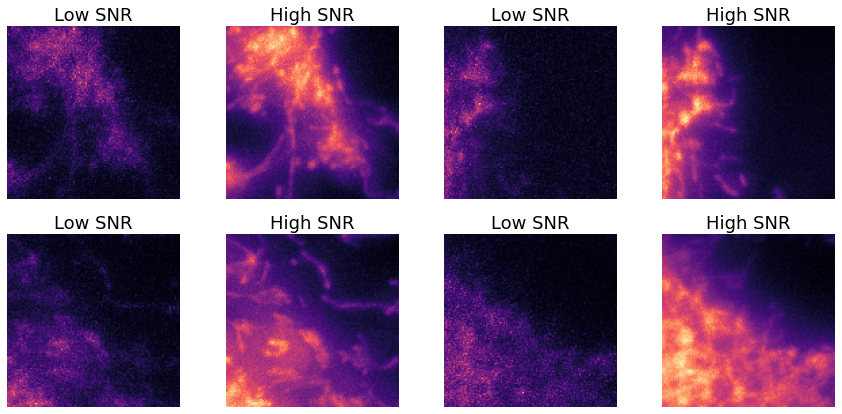

In [247]:
mip_x_train=np.max(x_train,axis=3)
mip_y_train=np.max(y_train,axis=3)

ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [248]:
model_save_directory = r"D:\Models\Data generator\widefield mitochondria\20220805-vahid\model\u2os-mitotracker-lp0.25-lg0.01.h5" 
load_model_save_directory = r"D:\Models\Data generator\widefield mitochondria\20220805-vahid\model\u2os-mitotracker-lp0.001-lg10.h5" 


n_epochs =  100
filters =[32,64,128,256]
# filters =[16,32,64,128]
num_filters = filters[0]
gen_lr = 5e-5

filters_cab=4
num_RG=2
num_RCAB=4

vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',
                                  input_tensor=Input(shape=(patch_size,patch_size,3)))

inter_vgg = []
LL = [1,2,4,5,7,8,9,11,12,13,15,16,17]
for i in LL:
    inter_vgg.append(Model(inputs=vgg.input, outputs=vgg.get_layer(vgg.layers[i].name).output))

def scheduler(epoch, lr):
    if np.mod(epoch+1,30)==0:
        return lr*0.6
    else:
        return lr

callbacks = [
    EarlyStopping(patience=100, verbose=1),
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

generator_input = Input((patch_size, patch_size,frame_end-frame_start,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape=(3, 3, 3),dropout=0.1)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
# generator.summary()


generator.load_weights(load_model_save_directory)
generator.compile(optimizer=gen_opt, loss=[generator_loss,generator_loss])


In [ ]:
results = generator.fit(x=x_train[0:200],y= [y_train[0:200],y_train[0:200]],batch_size=batch_size, epochs=n_epochs,verbose=1, callbacks=callbacks,validation_split=0.2)

Epoch 1/100
160/160 [==============================] - ETA: 0s - loss: 0.2266 - conv3d_2878_loss: 0.1129 - conv3d_2915_loss: 0.1137
Epoch 00001: val_loss improved from inf to 0.18707, saving model to D:\Models\Data generator\widefield mitochondria\20220805-vahid\model\u2os-mitotracker-lp0.25-lg0.01.h5
160/160 [==============================] - 80s 442ms/step - loss: 0.2266 - conv3d_2878_loss: 0.1129 - conv3d_2915_loss: 0.1137 - val_loss: 0.1871 - val_conv3d_2878_loss: 0.0955 - val_conv3d_2915_loss: 0.0916 - lr: 5.0000e-05
Epoch 2/100
160/160 [==============================] - ETA: 0s - loss: 0.1820 - conv3d_2878_loss: 0.0899 - conv3d_2915_loss: 0.0921
Epoch 00002: val_loss did not improve from 0.18707
160/160 [==============================] - 68s 427ms/step - loss: 0.1820 - conv3d_2878_loss: 0.0899 - conv3d_2915_loss: 0.0921 - val_loss: 0.3147 - val_conv3d_2878_loss: 0.1692 - val_conv3d_2915_loss: 0.1455 - lr: 5.0000e-05
Epoch 3/100
160/160 [==============================] - ETA: 0s -

In [14]:
test_GT = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\20220710\U2OS-DDX39B-JF646-1x-2\1\test\_4'
test_low = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\20220710\U2OS-DDX39B-JF646-1x-2\1\test\_1'

test_patch_size=512
frame_start=0
frame_end = 32
n_channel =  0


model_save_directory = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\20220710\U2OS-DDX39B-JF646-1x-2\1\ddx39b.h5"
filters_cab=4
num_RG=4
num_RCAB=4

filters = [32,64,128,256]
num_filters = filters[0]




gt_test,low_test=stack_generator(test_GT,test_low, fr_start=frame_start,fr_end=frame_end)
x_test, y_test,_,_ = data_generator(gt_test, low_test, test_patch_size, n_patches=1 ,n_channel=n_channel, threshold=0, ratio=1.0,
                                                    fr_start=frame_start,fr_end=frame_end,augment=False, shuffle=False)

generator_input = Input((test_patch_size, test_patch_size,frame_end-frame_start,1))
generator1 = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape=(3, 3, 3),dropout=0.3)

generator1.load_weights(model_save_directory)

prediction1 = np.zeros(x_test.shape)
prediction2 = np.zeros(x_test.shape)
for i in range(len(x_test)):
    prediction1[i]= generator1(x_test[i:i+1],training=False)
prediction1 = prediction1/prediction1.max()
prediction2 = prediction2/prediction2.max()
prediction1[prediction1<0]=0
prediction2[prediction2<0]=0

mip_x_test=np.max(x_test,axis=3)
mip_y_test=np.max(y_test,axis=3)
mip_prediction1=np.max(prediction1,axis=3)
mip_prediction2=np.max(prediction2,axis=3)

<tifffile.TiffFile '_4_MMStack_Pos18.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_4_MMStack_Pos18.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_4_MMStack_Pos19.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_4_MMStack_Pos20.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_1_MMStack_Pos18.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_1_MMStack_Pos18.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_1_MMStack_Pos19.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_1_MMStack_Pos20.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 


(3, 32, 1, 512, 512)
(3, 512, 512, 32, 1)
3
The training set shape is: (3, 512, 512, 32, 1)
The validation set shape is: (0, 512, 512, 32, 1)


ValueError: Layer count mismatch when loading weights from file. Model expected 99 layers, found 115 saved layers.

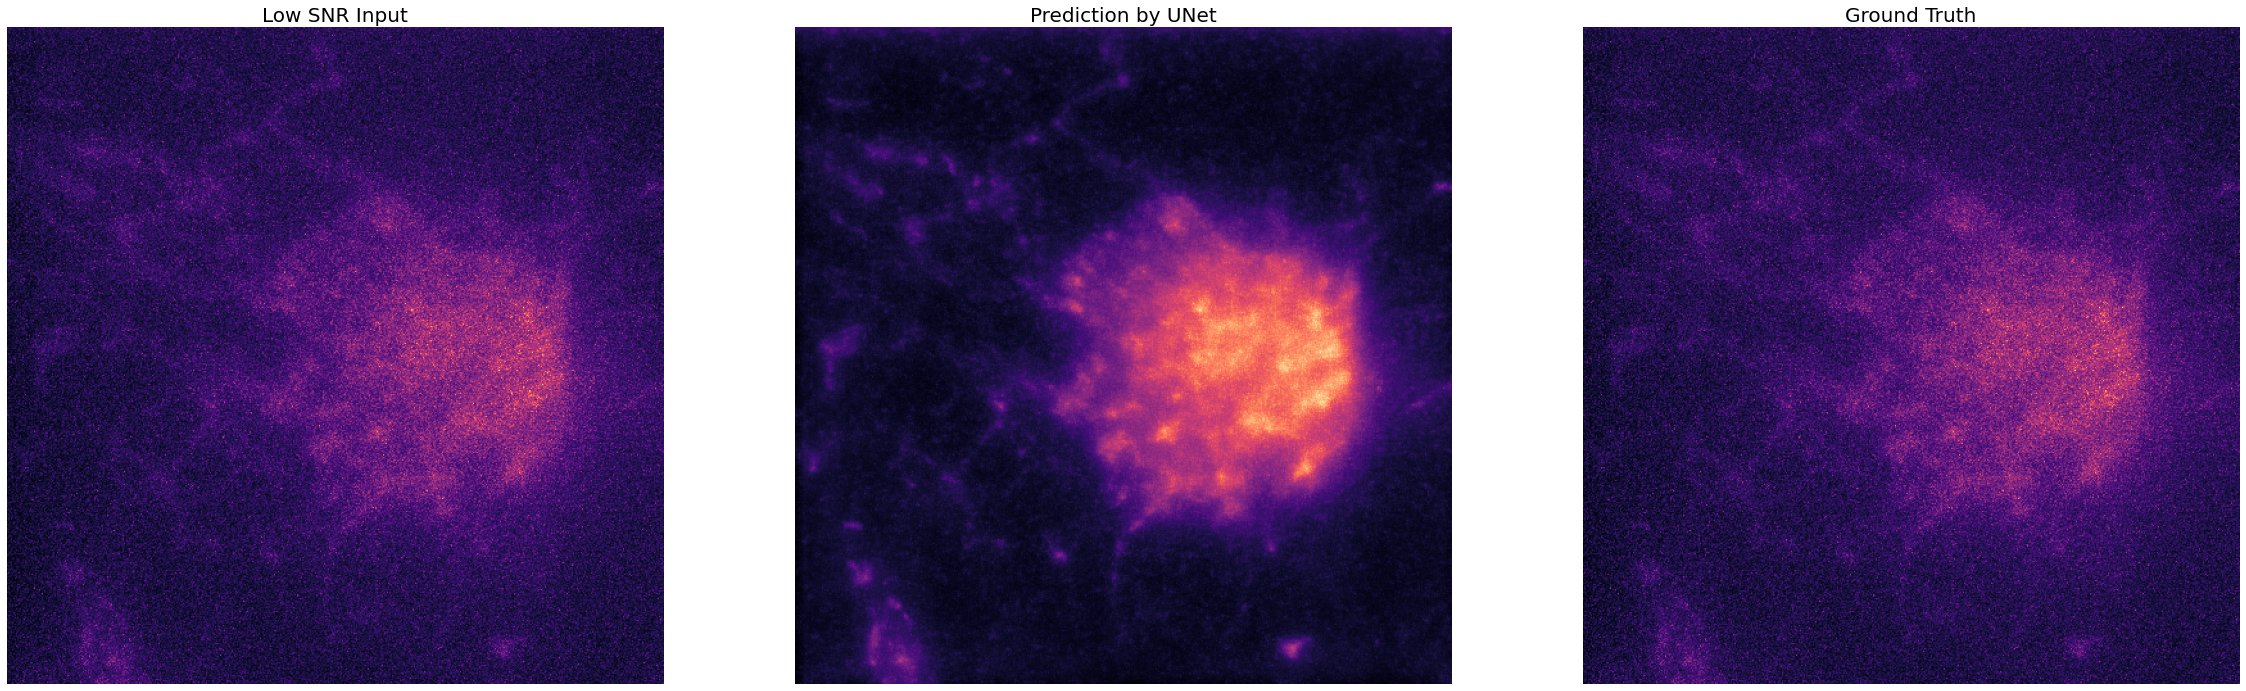

In [242]:
#@title **Cell 7: Visualize the Result of Prediction by a Trained GAN**

#@markdown The number of an image in the test set batch
# image_number =  10

ix = np.random.randint(len(mip_prediction1))
# ix = image_number-1
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 3, 1)
plt.imshow(mip_x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mip_prediction2[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by UNet',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mip_y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

In [243]:
#@title **Cell 8: Save the Prediction Results** { form-width: "50%" }

#@markdown Directory to Save the Prediction Results
save_image_dr = r"D:\Models\Data generator\widefield mitochondria\20220805-vahid\movie\New folder" #@param {type:"string"}


from tifffile import imwrite

pred1_test = np.moveaxis(prediction2,3,1)
X_test = np.moveaxis(x_test,3,1)
Y_test = np.moveaxis(y_test,3,1)


pred1_test = pred1_test*(2**16-1)
X_test = X_test*(2**16-1)
Y_test = Y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)
X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

imwrite(save_image_dr+'/prediction.tif', pred1_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})
imwrite(save_image_dr+'/x_test.tif', X_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})
imwrite(save_image_dr+'/y_test.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})

In [ ]:
#@title **Cell 9: Image quality assessment with NMSE, PSNR, and MS-SSIM** { form-width: "50%" }

#@markdown Directory to Save the Image Quality Assessment Results
save_parameters_dr = "/content/drive/MyDrive/WidefieldData/deconvolution/lp50/Parameters50ch1.csv" #@param {type:"string"}

def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.sim_multiscale(prediction.astype(np.float32), gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((6,len(prediction1)))

imageq_param[0::2,:] = nmse_psnr_ssim(mip_x_test,mip_y_test)
imageq_param[1::2,:] = nmse_psnr_ssim(mip_prediction1,mip_y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
labels = ['noisy', 'prediction']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE')

bplot2 = axes[1].boxplot([imageq_param[2,:],imageq_param[3,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR')

bplot3 = axes[2].boxplot([imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM')


np.savetxt(save_parameters_dr, np.transpose(imageq_param), delimiter=",")